# Spleen 3D segmentation with MONAI

This tutorial shows how to run SageMaker managed training using MONAI for 3D Segmentation.
This tutorial shows how to run SageMaker managed inference after model training. 



This notebook and train.py script in source folder were derived from [spleen_segmentation_3d notebook](https://github.com/Project-MONAI/tutorials/blob/master/3d_segmentation/spleen_segmentation_3d.ipynb)

Key features demonstrated here:
1. SageMaker managed training with S3 integration
2. SageMaker hosted inference 

The Spleen dataset can be downloaded from https://registry.opendata.aws/msd/.

![spleen](http://medicaldecathlon.com/img/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size
    

### Install and import monai libraries 

In [1]:
!pip install  "monai[all]==0.8.0"
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.
MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.


In [2]:
import numpy as np
import json
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImage,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import math
import ast
from pathlib import Path
import boto3
import sagemaker 
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch

MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.


In [3]:
#import sagemaker libraries and get environment variables
role = get_execution_role()
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket = sess.default_bucket()

## Prepare the dataset: Spleen dataset
+ Download the Spleen dataset if it is not available locally
+ Transform the images using Compose from MONAI
+ Visualize the image 

In [4]:
# Download the images
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"
compressed_file = "./Task09_Spleen.tar"

data_dir = "Spleen3D" 

if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, data_dir+'/datasets', md5)

In [5]:
## transform the images through Compose
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),  ## keys include image and label with image first
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

In [6]:
## divide the images into training and testing dataset
train_images = sorted(
    glob.glob(os.path.join(data_dir, "datasets/Task09_Spleen/imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "datasets/Task09_Spleen/labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, test_demo_files = data_dicts[:-1], data_dicts[-1:]

image shape: torch.Size([233, 209, 101]), label shape: torch.Size([233, 209, 101])


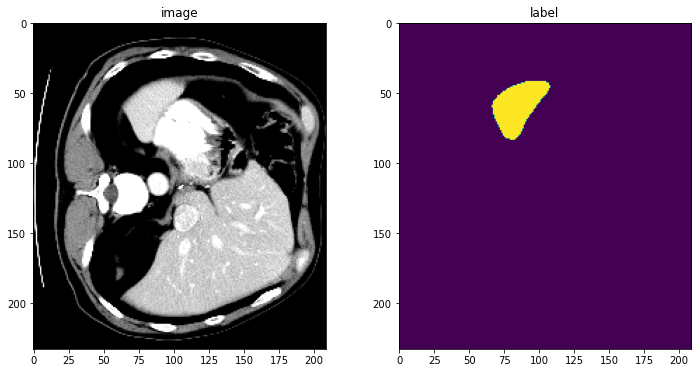

In [7]:
# Visualization
check_ds = Dataset(data=test_demo_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)

image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot only the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

## Model training 

+ Divide the dataset into training and testing
+ Upload the dataset into S3 
+ SageMaker training job

In [8]:
prefix="MONAI_Segmentation"

processed_train_path = os.path.join(data_dir,"processed","train")
processed_test_path = os.path.join(data_dir,"processed","test")

processed_train_images_path = os.path.join(processed_train_path, "imagesTr")
processed_train_labels_path = os.path.join(processed_train_path, "labelsTr")

processed_test_images_path = os.path.join(processed_test_path, "imagesTr")
processed_test_labels_path = os.path.join(processed_test_path, "labelsTr")

Path(processed_train_images_path).mkdir(parents=True, exist_ok=True)
Path(processed_train_labels_path).mkdir(parents=True, exist_ok=True)
print("Directory '%s' created" %processed_train_path)

Path(processed_test_images_path).mkdir(parents=True, exist_ok=True)
Path(processed_test_labels_path).mkdir(parents=True, exist_ok=True)
print("Directory '%s' created" %processed_test_path)

Directory 'Spleen3D/processed/train' created
Directory 'Spleen3D/processed/test' created


In [9]:
## copy dataset for training 
for file in train_files:
    images = file['image']
    images_dest = processed_train_images_path
    label = file['label']
    label_dest = processed_train_labels_path
    shutil.copy(images,images_dest)
    shutil.copy(label,label_dest)

In [10]:
## copy dataset for training 
for file in train_files:
    images = file['image']
    images_dest = processed_train_images_path
    label = file['label']
    label_dest = processed_train_labels_path
    shutil.copy(images,images_dest)
    shutil.copy(label,label_dest)

In [11]:
## upload training dataset to S3
S3_inputs = sess.upload_data(
    path=processed_train_path,
    key_prefix=prefix+"/train",
    bucket=bucket 
)

## upload testing dataset to S3
S3_demo_test = sess.upload_data(
    path=processed_test_images_path,
    key_prefix=prefix+"/demo_test",
    bucket=bucket 
)

In [12]:
## upload testing dataset (no labels)
img_test_path = os.path.join(data_dir, "datasets/Task09_Spleen/imagesTs")

S3_img_test = sess.upload_data(
    path=img_test_path,
    key_prefix=prefix+"/img_test",
    bucket=bucket 
)

### SageMaker training job

In [97]:
%%time

metrics=[
   {'Name': 'train:average epoch loss', 'Regex': 'average loss: ([0-9\\.]*)'},
   {'Name': 'train:current mean dice', 'Regex': 'current mean dice: ([0-9\\.]*)'},
   {'Name': 'train:best mean dice', 'Regex': 'best mean dice: ([0-9\\.]*)'}
]

estimator = PyTorch(source_dir='code',
                    entry_point='train.py',
                    role=role,
                    framework_version='1.6.0',
                    py_version='py3',
                    instance_count=1,
#                     instance_type='ml.p2.xlarge',
                    instance_type='ml.p3.2xlarge',
                    hyperparameters={
                       "seed": 123,
                       "lr": 0.001,
                       "epochs": 200
                    },
                    metric_definitions=metrics,
#                     ### spot instance training ###
#                    use_spot_instances=True,
#                     max_run=2400,
#                     max_wait=2400
                )


estimator.fit(S3_inputs)

2022-05-03 23:22:27 Starting - Starting the training job...
2022-05-03 23:22:53 Starting - Preparing the instances for trainingProfilerReport-1651620147: InProgress
.........
2022-05-03 23:24:11 Downloading - Downloading input data...
2022-05-03 23:24:51 Training - Downloading the training image...........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-05-03 23:26:35,149 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-05-03 23:26:35,178 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-05-03 23:26:35,186 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-05-03 23:26:35,556 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.6 -m pip install -r requirements.txt
  Installing build dependencies: started
  Installing build dependencies: finished wi

## Inference 

+ deploy the model with customized inference script
+ inference with testing image in S3
+ visualization the results
+ deployment with trained estimator or the model artifact in S3.

The endpoint will return two types of output. If an integer is provided, it will return the inference result. If a start slice and end slice is provided, it will return the location of S3 where the result is saved.

### Real time inference endpoint

In [99]:
## realtime endpoint

predictor = estimator.deploy(
    initial_instance_count=1,
    source_dir='code',
    entry_point='inference.py', 
    instance_type='ml.m5.4xlarge',
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer()
)

------!

In [38]:
prefix_key = prefix+"/demo_test"
file = test_demo_files[0]["image"].split("/")[-1]
print(file)

spleen_9.nii.gz


In [39]:
#run either this cell or the next
totalslice = np.array(image).shape[-1]
# totalslice = 30 #comment out if using the entire scan
print(totalslice)
nslice = 50 #must be at least 1 less than total slice

101


In [70]:
#optional
nslicestart=50
nsliceend=55

In [71]:
%%time
test_demo_preds=[]
# for counter in range(totalslice):
for counter in range(int(nslicestart),int(nsliceend)): #comment out if using slicestart and sliceend
    payload={
        "bucket": bucket,
        "key": prefix_key,
        "file": file,
        "nslice": counter
            }
    response_pred=predictor.predict(payload)
    print("inference for slice",counter)
    test_demo_preds.append(response_pred)

inference for slice 50
inference for slice 51
inference for slice 52
inference for slice 53
inference for slice 54
CPU times: user 46 ms, sys: 6.96 ms, total: 53 ms
Wall time: 44 s


In [72]:
test_demo_ds = check_ds
test_demo_loader = check_loader
test_demo_data = check_data

In [73]:
nslice = 0
torch.tensor(test_demo_preds[nslice]['pred'])

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

### Visualize the result

image shape: torch.Size([233, 209, 101]), label shape: torch.Size([233, 209, 101])


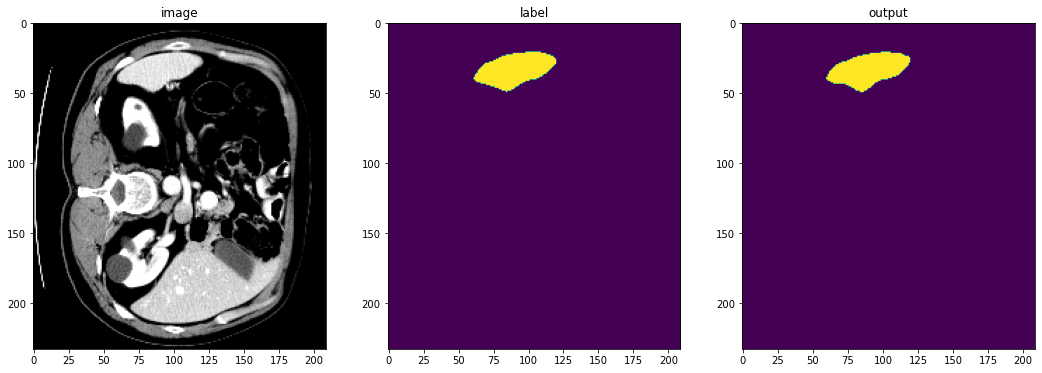

In [74]:
image, label = (test_demo_data["image"][0][0], test_demo_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

# Visualization
# plot the slice [:, :, nslice]
plt.figure("check", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(test_demo_data["image"][0, 0, :, :, nslicestart+nslice], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(test_demo_data["label"][0, 0, :, :, nslicestart+nslice])
plt.subplot(1, 3, 3)
plt.title("output")
plt.imshow(test_demo_preds[nslice]['pred'])

plt.show()

#### Unlabeled test data

In [52]:
test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear")),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys=["image"]),
    ]
)

In [53]:
loader = LoadImage()

test_images = sorted(glob.glob(os.path.join(img_test_path, "*.nii.gz")))
test_dicts = [{"image": image_name} for image_name in test_images]

test_ds = Dataset(data=test_dicts, transform=test_org_transforms)
test_loader = DataLoader(test_ds, batch_size=1)
test_data = first(test_loader)

In [108]:
%timeit
# inference
infer_key = prefix+"/img_test"
slicesstart = 50
slicesend = 57
# img_ls = range(len(test_dicts))
img_ls = range(3) #swap out if you want to use the full set of images

predictions = []
for item in img_ls:
    infer_file = test_dicts[item]["image"].split("/")[-1]
    print(f"Started prediction for image {infer_file}")
    img = test_data["image"][0][0][item]
    
#     slices = np.array(img).shape[-1]
    slices = 50 #swap out if you want to use the full scan
    slicesstart = slicesstart
    slicesend = slicesend

    pred_img = []
#     for count in range(slices):
    for count in range(int(slicesstart),int(slicesend)):
        payload={
            "bucket": bucket,
            "key": infer_key,
            "file": infer_file,
            "nslice": count
                }
        response_test=predictor.predict(payload)
        print("slice", count)
        pred_img.append(response_test)
    predictions.append(pred_img)
    print(f"Completed prediction for image {infer_file}")

Started prediction for image spleen_1.nii.gz
slice 50
slice 51
slice 52
slice 53
slice 54
slice 55
slice 56
Completed prediction for image spleen_1.nii.gz
Started prediction for image spleen_11.nii.gz
slice 50
slice 51
slice 52
slice 53
slice 54
slice 55
slice 56
Completed prediction for image spleen_11.nii.gz
Started prediction for image spleen_15.nii.gz
slice 50
slice 51
slice 52
slice 53
slice 54
slice 55
slice 56
Completed prediction for image spleen_15.nii.gz


In [109]:
item = 2
sliceno = 3
slices = test_dicts[item]["image"].split("/")[-1]
print(slices)
torch.tensor(predictions[item][sliceno]["pred"]).size()

spleen_15.nii.gz


torch.Size([226, 188])

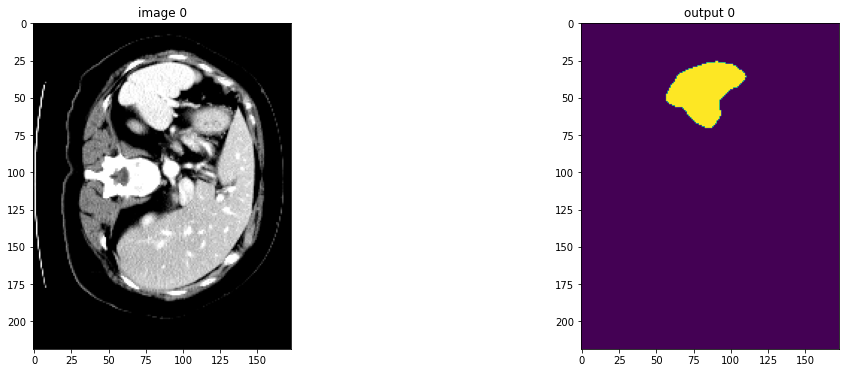

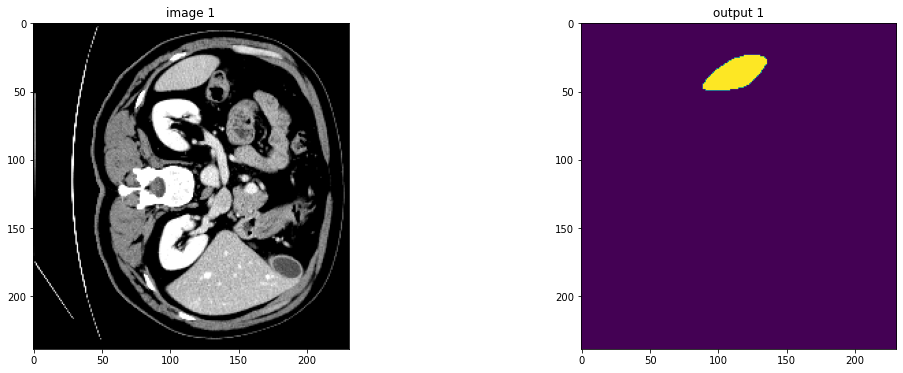

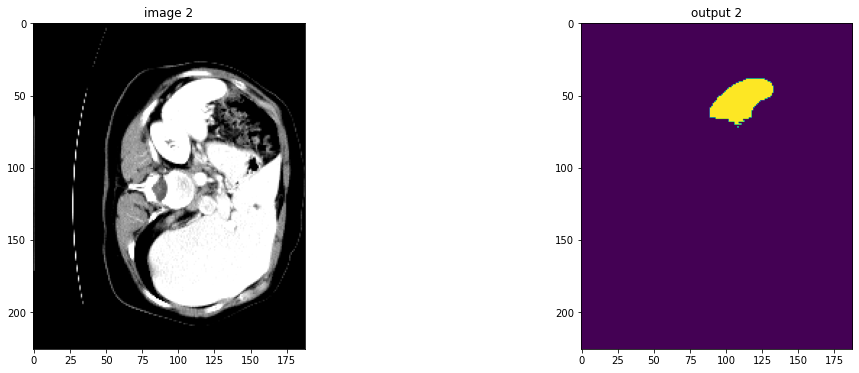

In [110]:
for i, test_data in enumerate(test_loader):
    # plot the slice [:, :, sliceno]
    plt.figure("check", (18, 6))
    plt.subplot(1, 2, 1)    
    plt.title(f"image {i}")
    plt.imshow(test_data["image"][0][0, :, :, sliceno+slicesstart], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title(f"output {i}")
    plt.imshow(predictions[i][sliceno]["pred"])
    plt.show()    
    if i+1 == len(img_ls):
        break

In [111]:
%%time
slicestart=70
sliceend=75
slicerange = f"{slicestart}:{sliceend}"

payload_multi={
    "bucket": bucket,
    "key": prefix_key,
    "file": file,
    "nslice": slicerange
        }

response_multi_pred=predictor.predict(payload_multi)

CPU times: user 3.6 ms, sys: 0 ns, total: 3.6 ms
Wall time: 8.79 s


In [112]:
multi_output_file = response_multi_pred["s3_path"]

In [113]:
download_response = sagemaker.s3.S3Downloader.read_file(multi_output_file, sagemaker_session=sess)

In [114]:
multi_output_json = ast.literal_eval(download_response)
multi_output = multi_output_json["pred"]

In [115]:
output_array = np.array(multi_output)
output_array.shape

(233, 209, 5)

image shape: torch.Size([233, 209, 101]), label shape: torch.Size([233, 209, 101])


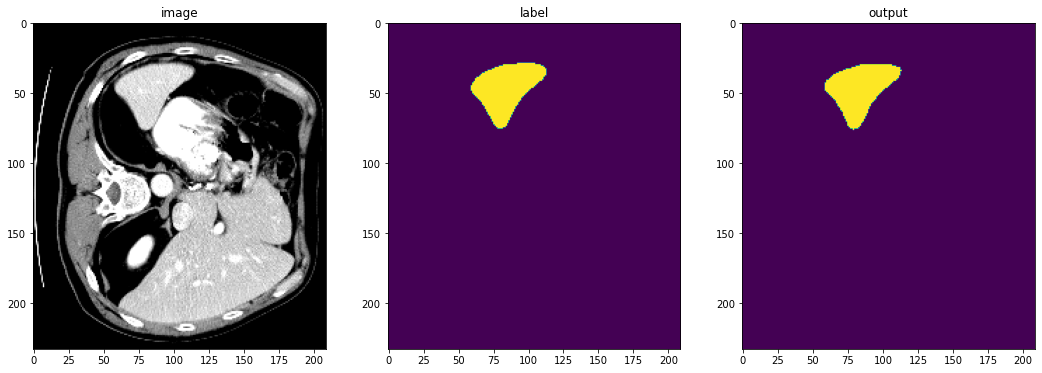

image shape: torch.Size([233, 209, 101]), label shape: torch.Size([233, 209, 101])


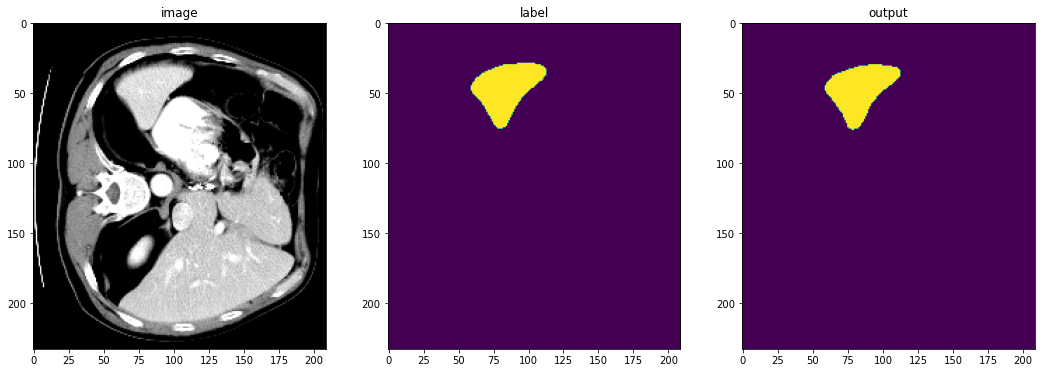

image shape: torch.Size([233, 209, 101]), label shape: torch.Size([233, 209, 101])


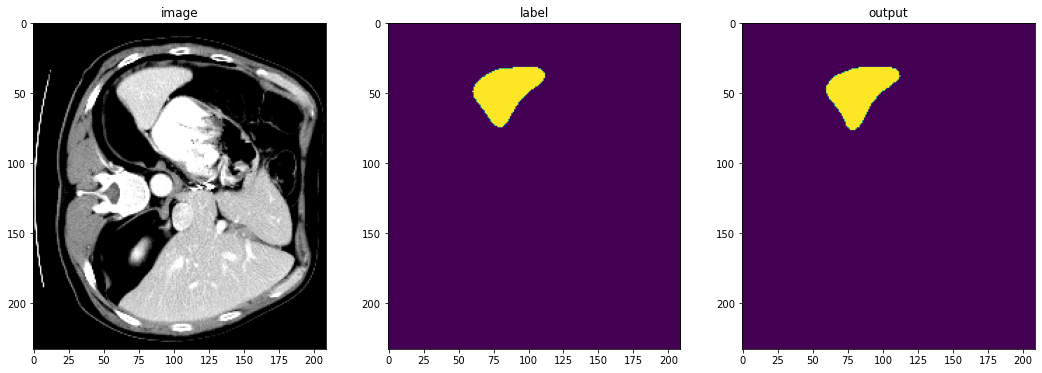

image shape: torch.Size([233, 209, 101]), label shape: torch.Size([233, 209, 101])


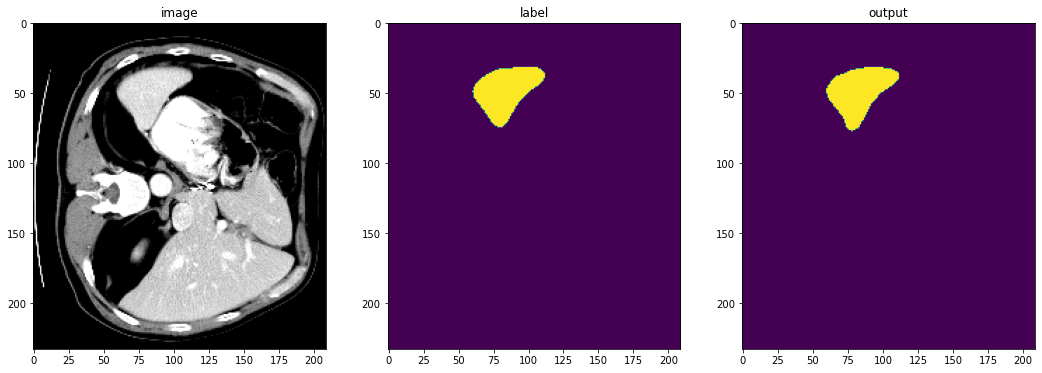

image shape: torch.Size([233, 209, 101]), label shape: torch.Size([233, 209, 101])


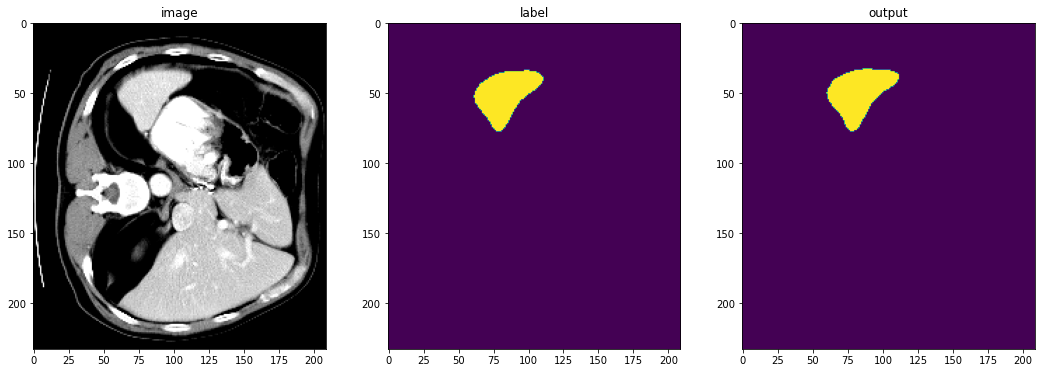

In [116]:
for nslice in range(output_array.shape[-1]):
#     nslice = multi_output[:,:,j]
    image1, label1 = (test_demo_data["image"][0][0], test_demo_data["label"][0][0])
    print(f"image shape: {image1.shape}, label shape: {label1.shape}")

    # Visualization
    # plot the slice [:, :, nslice]
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(test_demo_data["image"][0, 0, :, :, slicestart+nslice], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(test_demo_data["label"][0, 0, :, :, slicestart+nslice])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(output_array[:,:,nslice])

    plt.show()

In [100]:
%%time

payload_all={
    "bucket": bucket,
    "key": prefix_key,
    "file": file,
    "nslice": "all"
        }

response_all_pred=predictor.predict(payload_all)

CPU times: user 8.67 ms, sys: 2.96 ms, total: 11.6 ms
Wall time: 9.65 s


In [101]:
all_output_file = response_all_pred["s3_path"]

In [102]:
download_all_response = sagemaker.s3.S3Downloader.read_file(all_output_file, sagemaker_session=sess)

In [103]:
all_output_json = ast.literal_eval(download_all_response)
all_output = all_output_json["pred"]

In [104]:
output_all_array = np.array(all_output)
output_all_array.shape

(233, 209, 101)

In [105]:
n_all_slice = 45

image shape: torch.Size([233, 209, 101]), label shape: torch.Size([233, 209, 101])


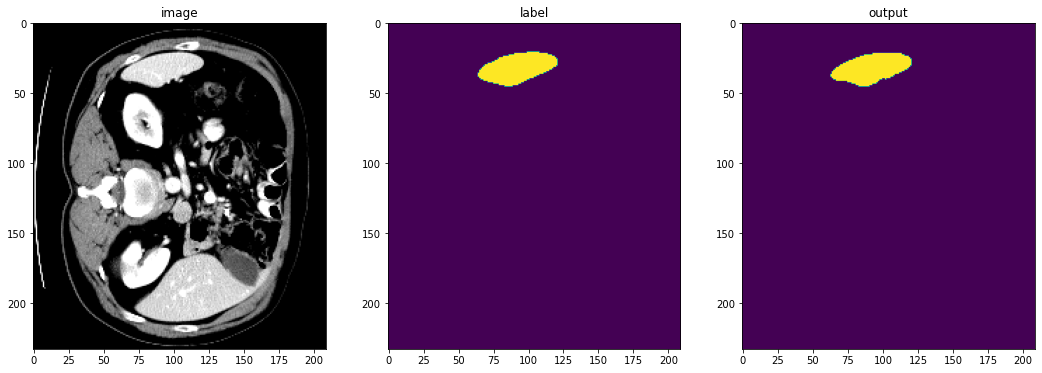

In [107]:
image2, label2 = (test_demo_data["image"][0][0], test_demo_data["label"][0][0])
print(f"image shape: {image2.shape}, label shape: {label2.shape}")

# Visualization
# plot the slice [:, :, nslice]
plt.figure("check", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(test_demo_data["image"][0, 0, :, :, n_all_slice], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(test_demo_data["label"][0, 0, :, :, n_all_slice])
plt.subplot(1, 3, 3)
plt.title("output")
plt.imshow(output_all_array[:,:,n_all_slice])

plt.show()

## Clean up the resources

+ delete the current endpoint or all the endpoints to save cost

In [ ]:
predictor.delete_predictor(delete_endpoint_config=True)

In [ ]:
client = boto3.client('sagemaker')
endpoints=client.list_endpoints()['Endpoints']
endpoints

In [ ]:
# for endpoint in endpoints:
#     response = client.delete_endpoint(
#         EndpointName=endpoint['EndpointName']
#     )